In [2]:
%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

# Training Setup

In [3]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cpu")
train_size=0.00108

# Losses
l2loss    = nn.MSELoss(reduction="sum")

In [4]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            epoch_loss, epoch_kl = train(model, train_loader, optimizer, l2loss, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)

            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
                

            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_l2_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                print("\n", log)

                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)
                axs[0, 0].imshow(recon[0].permute(1,2,0).cpu().detach().numpy(), vmin=0., vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0].permute(1,2,0).cpu().detach().numpy(), vmin=0., vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0].permute(1,2,0).cpu().detach().numpy() - recon[0].permute(1,2,0).cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")
                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="l2loss")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# CIFAR10 Example

## Datasets and Dataloaders

In [5]:
# Train Transforms
train_transform = Compose([
    Resize(28),
])

# Datasets and dataloaders
ds = CIFAR10("./", download=True, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = torch.from_numpy(ds.data[train_idx]) / 255., torch.tensor(ds.targets)[train_idx]
X_train = X_train.permute(0, 3, 1, 2)
trainds = TransformTensorDataset(X_train.float(), y_train.float(), transform=train_transform)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

Files already downloaded and verified
Trainable Images: 54
torch.Size([1, 3, 28, 28]) 0.014325735159218311 1.0


## Autoencoder FC

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06711354851722717, 'train_l2_loss': 4347.27880859375, 'train_kl_loss': 0.0}


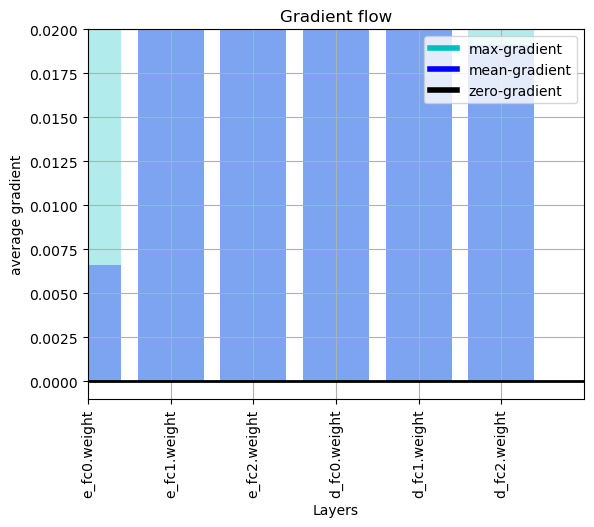

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


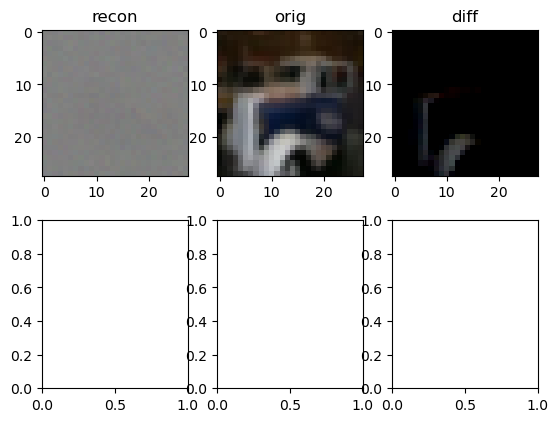

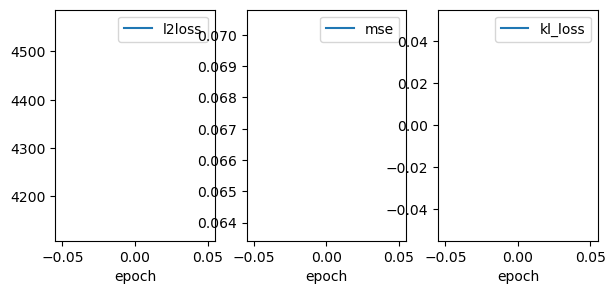

 20% (20 of 100) |####                   | Elapsed Time: 0:00:07 ETA:   0:00:27


 {'epoch': 20, 'train_mse': 0.03421717509627342, 'train_l2_loss': 2192.8056640625, 'train_kl_loss': 0.0}


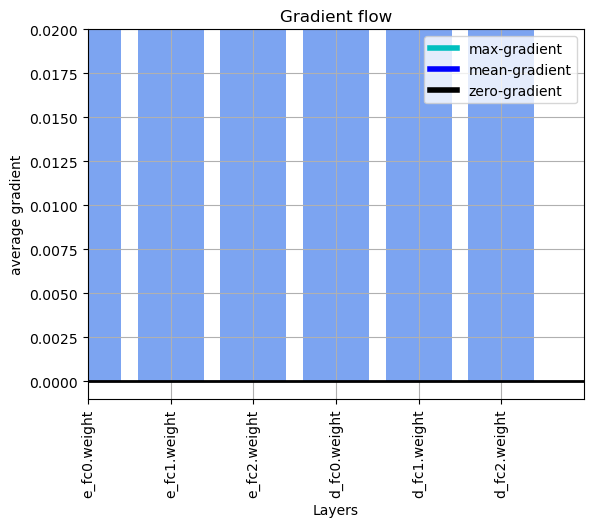

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


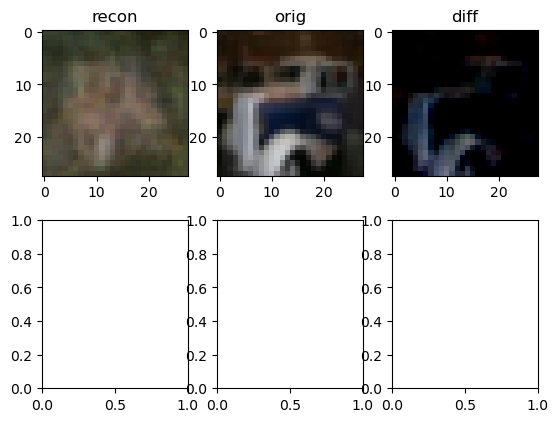

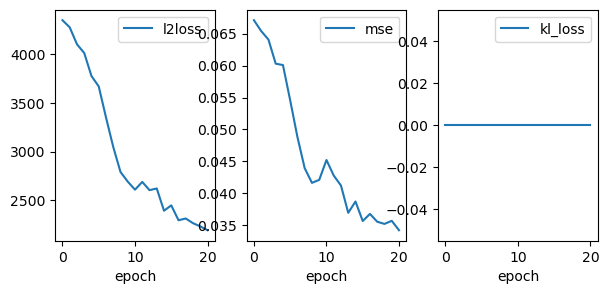

 40% (40 of 100) |#########              | Elapsed Time: 0:00:15 ETA:   0:00:20


 {'epoch': 40, 'train_mse': 0.026517046615481377, 'train_l2_loss': 1758.9461669921875, 'train_kl_loss': 0.0}


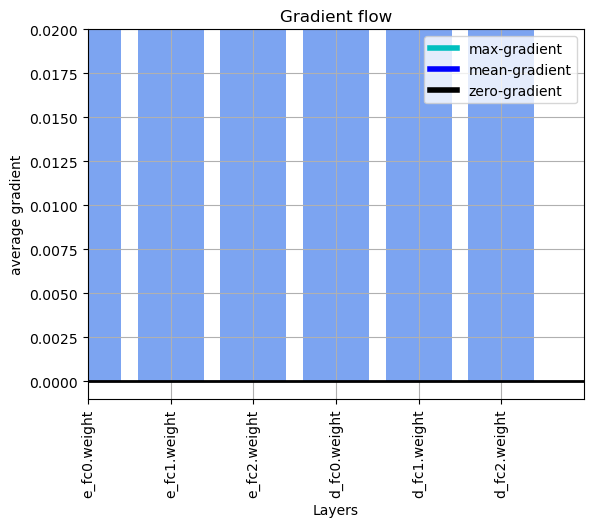

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


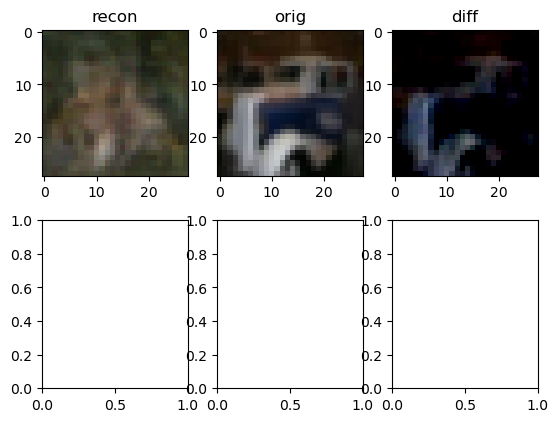

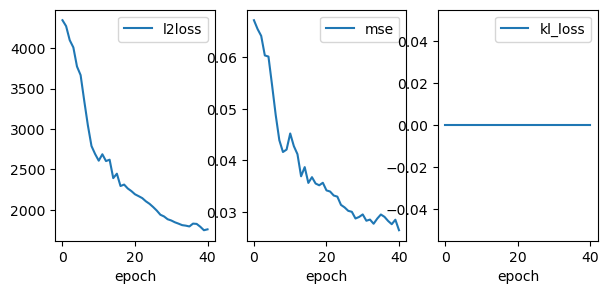

 60% (60 of 100) |#############          | Elapsed Time: 0:00:22 ETA:   0:00:13


 {'epoch': 60, 'train_mse': 0.021760784089565277, 'train_l2_loss': 1391.1201171875, 'train_kl_loss': 0.0}


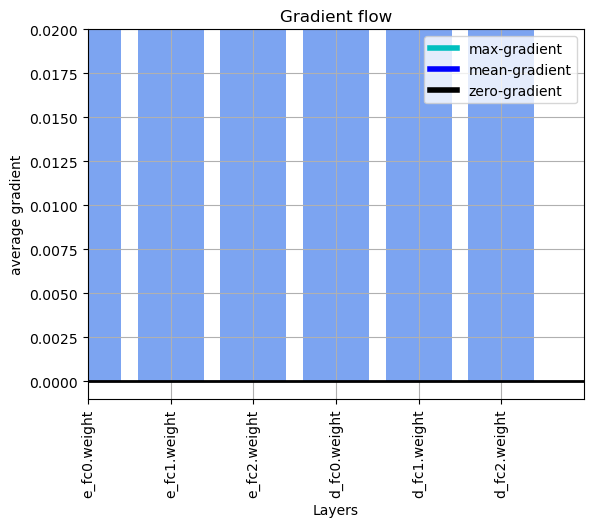

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


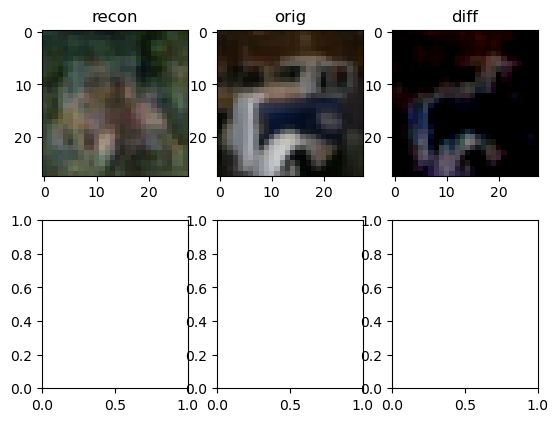

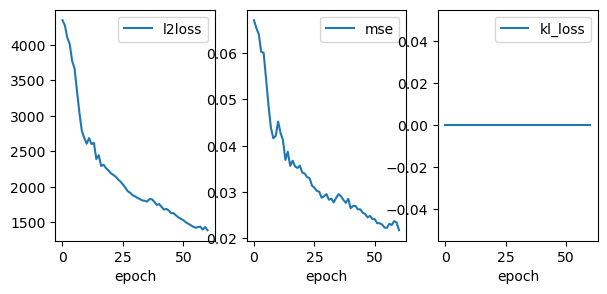

 80% (80 of 100) |##################     | Elapsed Time: 0:00:30 ETA:   0:00:07


 {'epoch': 80, 'train_mse': 0.011799214407801628, 'train_l2_loss': 772.7861938476562, 'train_kl_loss': 0.0}


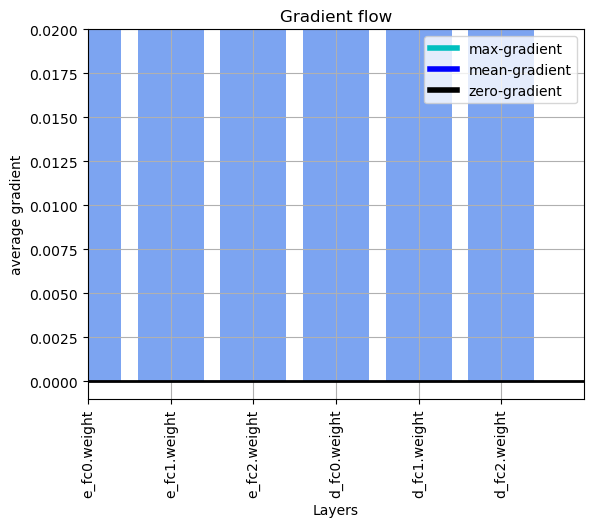

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


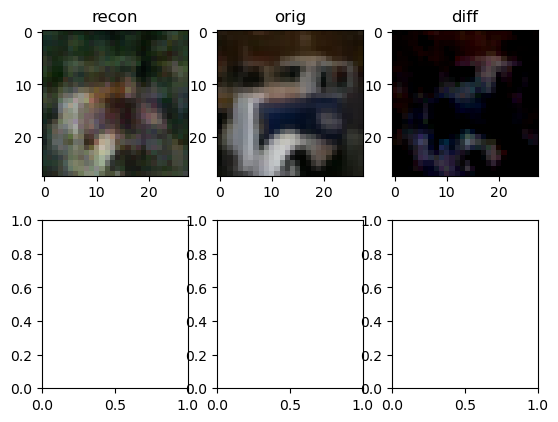

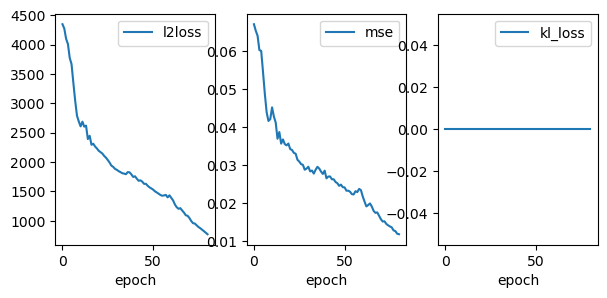

 99% (99 of 100) |###################### | Elapsed Time: 0:00:37 ETA:   0:00:00


 {'epoch': 99, 'train_mse': 0.011421497911214828, 'train_l2_loss': 779.72900390625, 'train_kl_loss': 0.0}


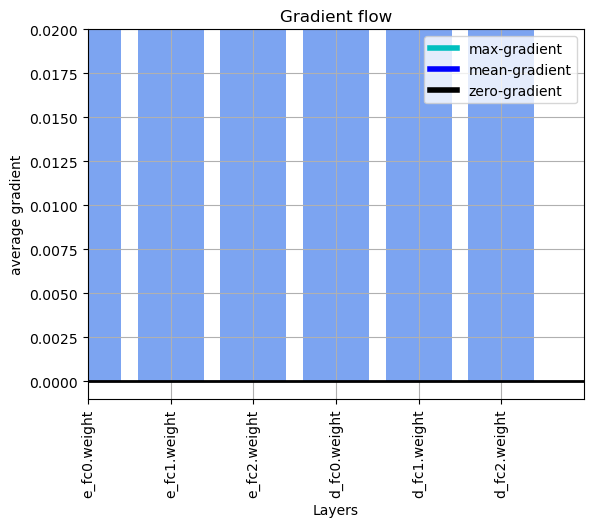

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


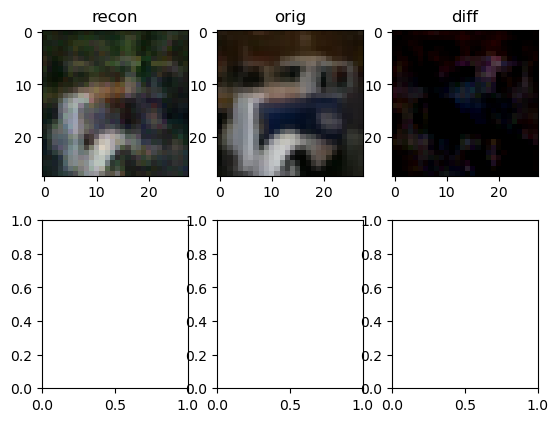

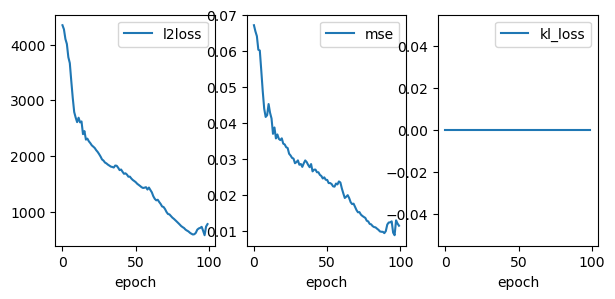

100% (100 of 100) |######################| Elapsed Time: 0:00:38 Time:  0:00:38


In [6]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, vis_frequency=20)

## Visualise Loss Landscape of Autoencoder (FC)

Train Subset len:  16
Angle between x_dir and y_dir: 90.04 °


100% (625 of 625) |######################| Elapsed Time: 0:00:56 Time:  0:00:56


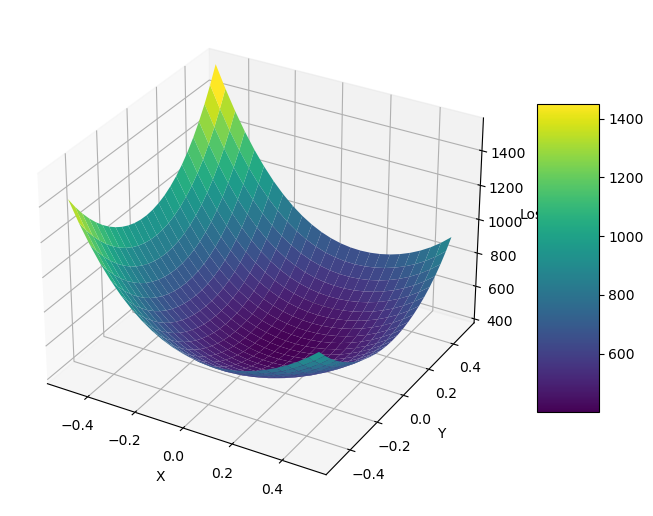

In [7]:
train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Train Subset len: ", len(train_subset))
xx, yy, loss_landscape = visualise_landscape(model, train_subloader, l2loss, device=device)


## Variational Autoencoder (FC)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06803262233734131, 'train_l2_loss': 4372.291015625, 'train_kl_loss': 585.719970703125}


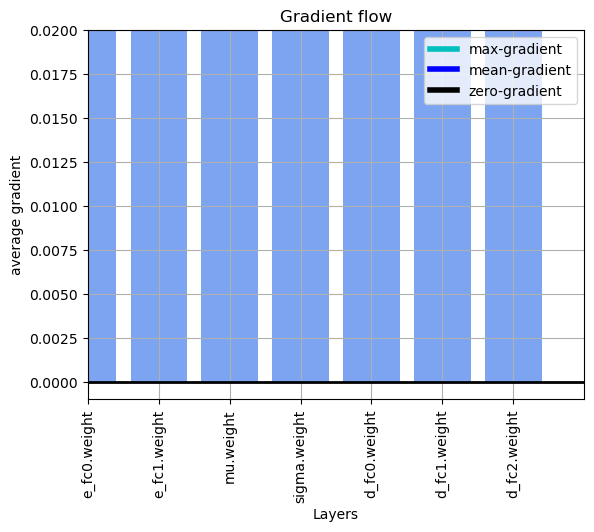

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


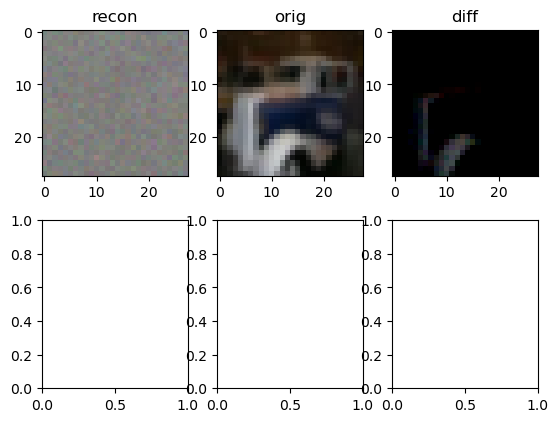

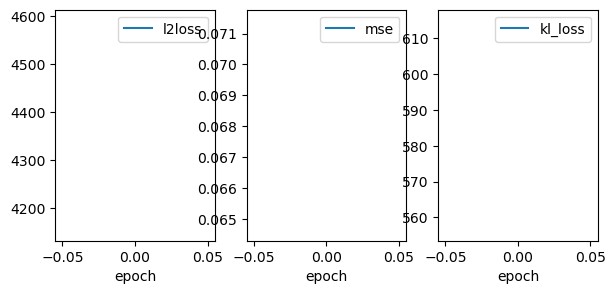

 20% (20 of 100) |####                   | Elapsed Time: 0:00:08 ETA:   0:00:29


 {'epoch': 20, 'train_mse': 0.04170747473835945, 'train_l2_loss': 2685.5517578125, 'train_kl_loss': 707.5054321289062}


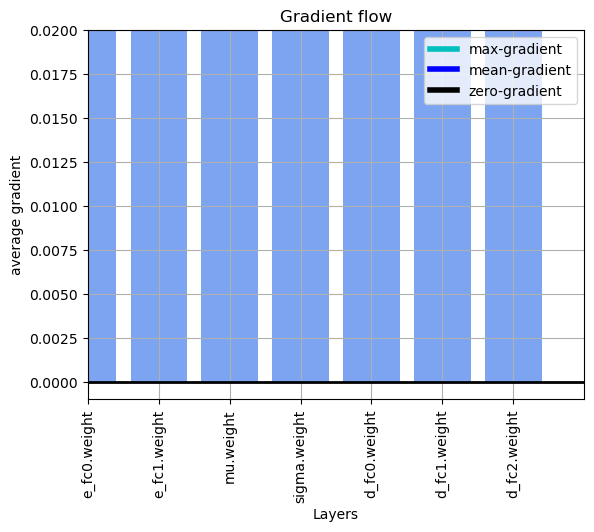

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


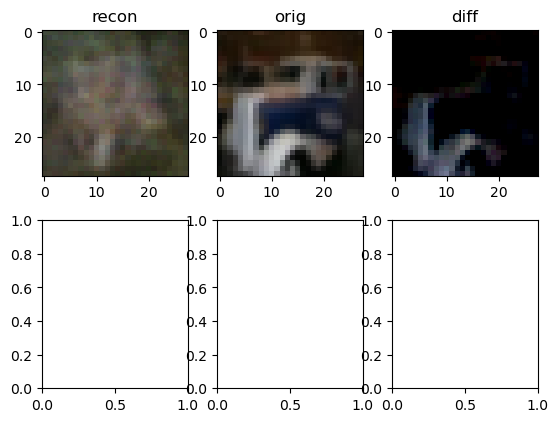

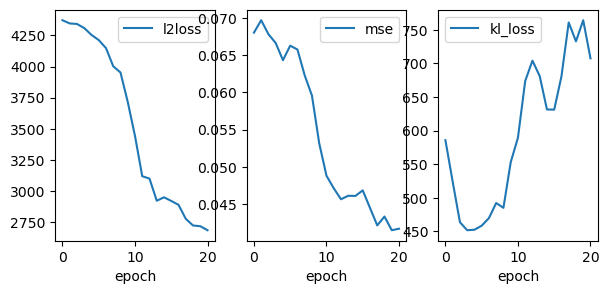

 40% (40 of 100) |#########              | Elapsed Time: 0:00:16 ETA:   0:00:22


 {'epoch': 40, 'train_mse': 0.037481360137462616, 'train_l2_loss': 2316.11767578125, 'train_kl_loss': 728.4072265625}


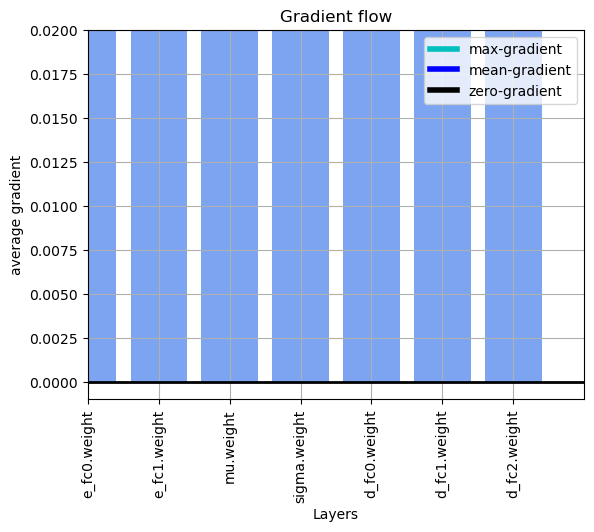

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


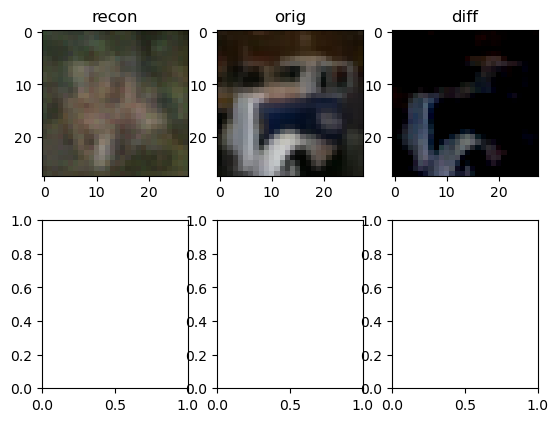

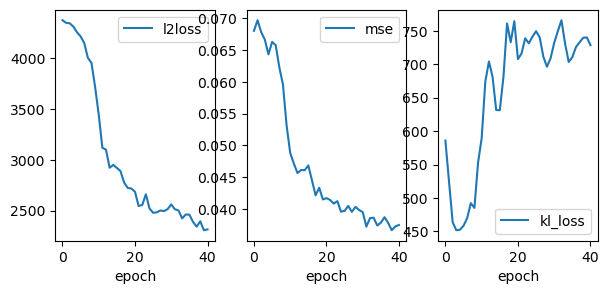

 60% (60 of 100) |#############          | Elapsed Time: 0:00:24 ETA:   0:00:14


 {'epoch': 60, 'train_mse': 0.032961226999759674, 'train_l2_loss': 2073.049560546875, 'train_kl_loss': 811.7489013671875}


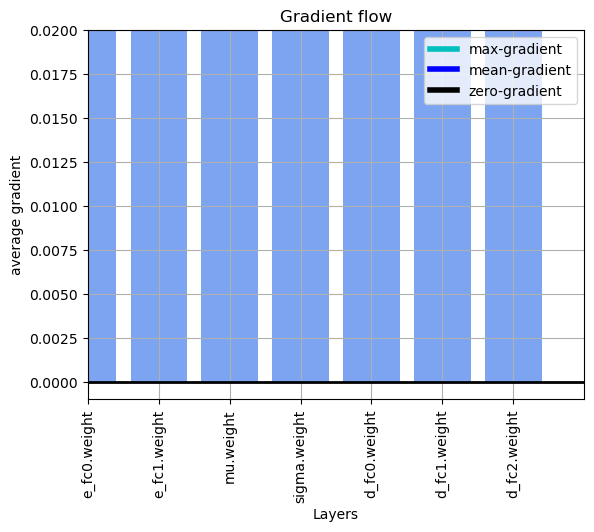

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


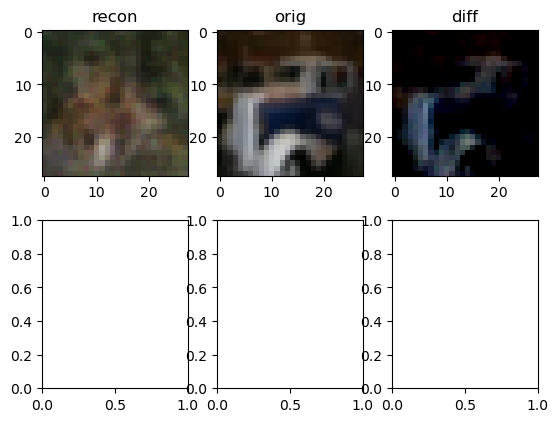

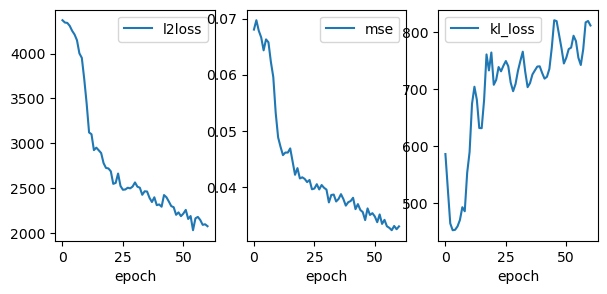

 80% (80 of 100) |##################     | Elapsed Time: 0:00:32 ETA:   0:00:07


 {'epoch': 80, 'train_mse': 0.029893727973103523, 'train_l2_loss': 1934.416748046875, 'train_kl_loss': 827.2759399414062}


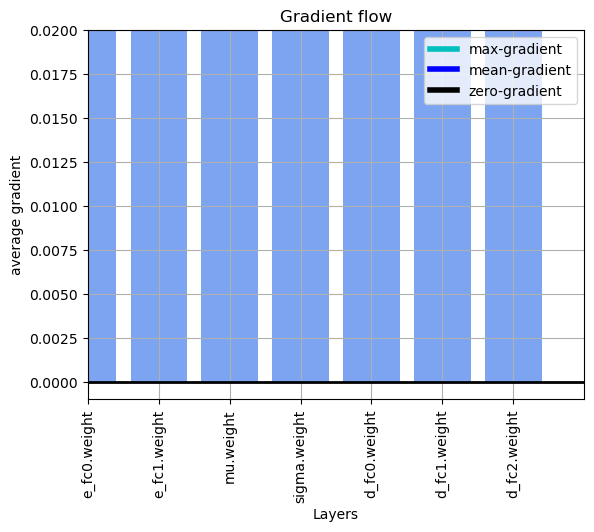

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


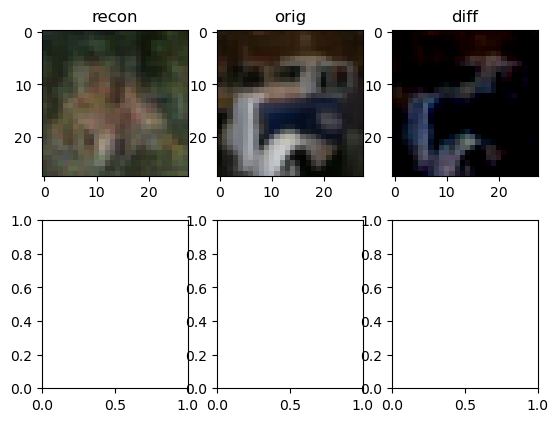

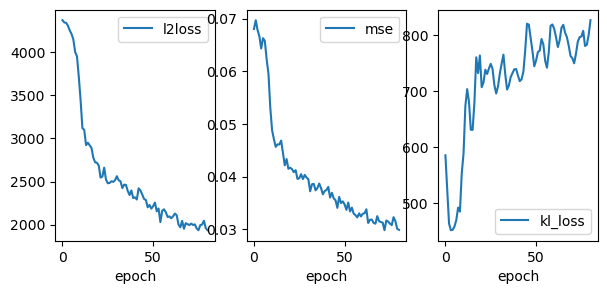

 99% (99 of 100) |###################### | Elapsed Time: 0:00:41 ETA:   0:00:00


 {'epoch': 99, 'train_mse': 0.028317347168922424, 'train_l2_loss': 1849.9296875, 'train_kl_loss': 791.4938354492188}


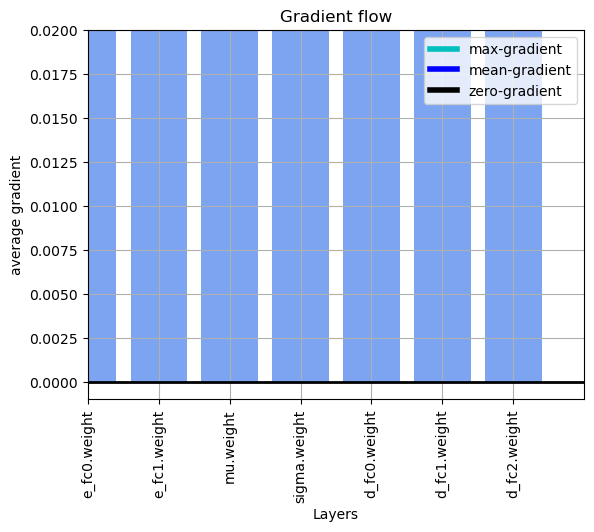

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


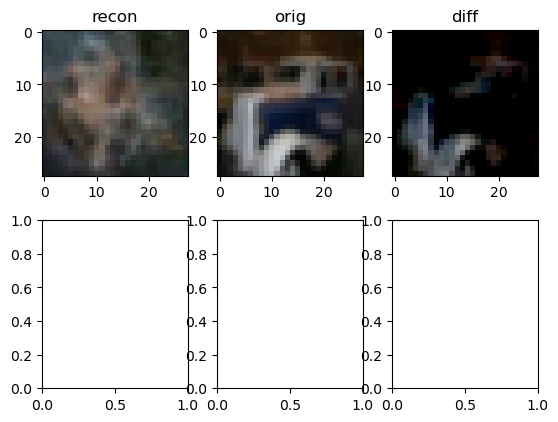

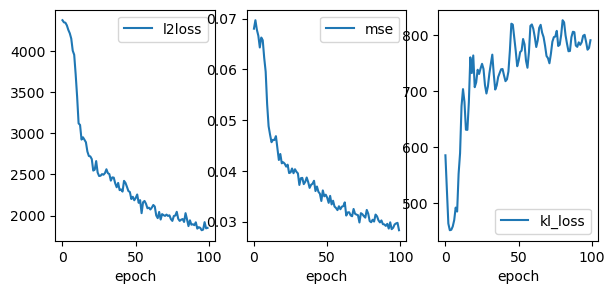

100% (100 of 100) |######################| Elapsed Time: 0:00:41 Time:  0:00:41


In [8]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
 
# Train and visualise
train_model(model, optimizer, train_loader, nepochs, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06825492531061172, 'train_l2_loss': 4342.7109375, 'train_kl_loss': 0.0}


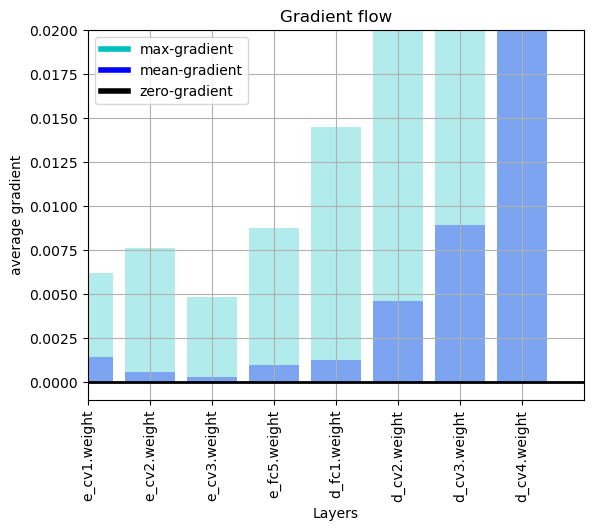

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


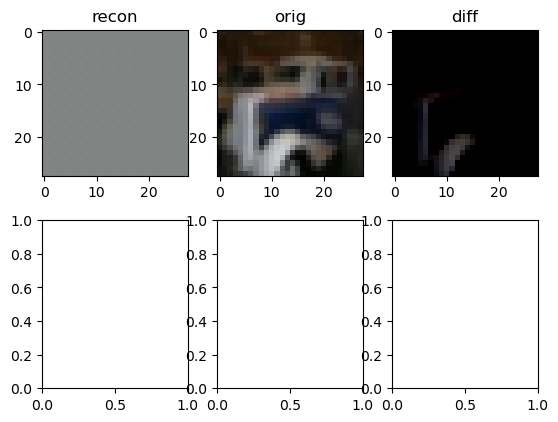

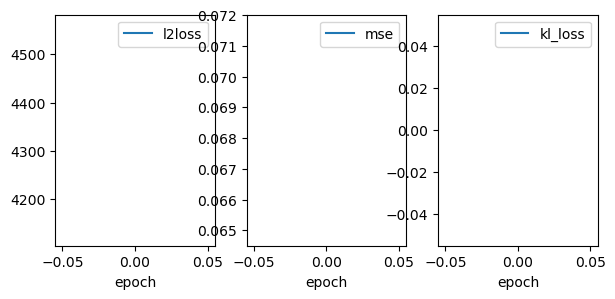

 20% (20 of 100) |####                   | Elapsed Time: 0:00:09 ETA:   0:00:32


 {'epoch': 20, 'train_mse': 0.04719705507159233, 'train_l2_loss': 3073.63525390625, 'train_kl_loss': 0.0}


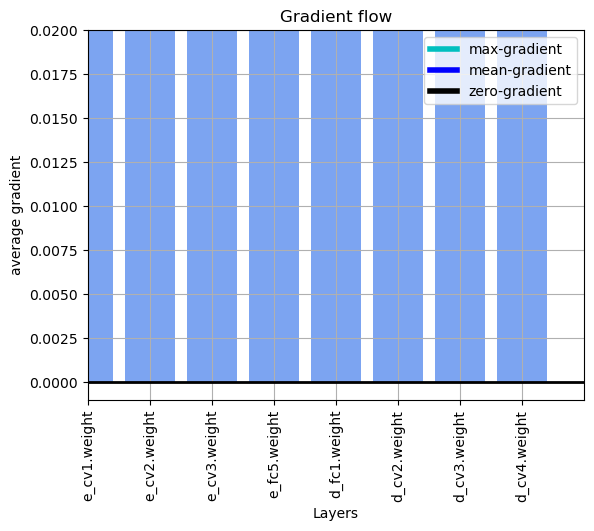

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


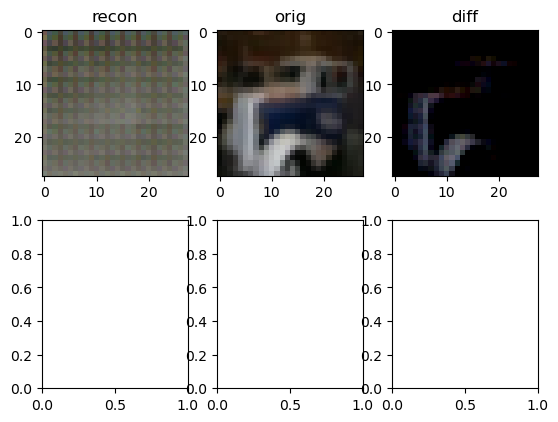

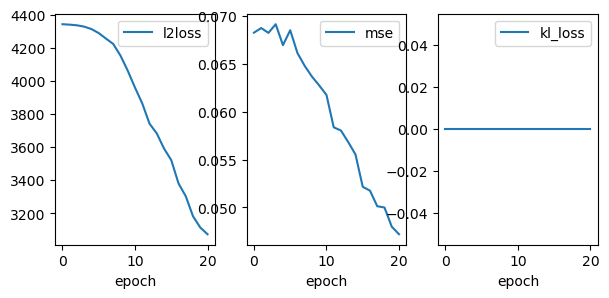

 40% (40 of 100) |#########              | Elapsed Time: 0:00:18 ETA:   0:00:24


 {'epoch': 40, 'train_mse': 0.03516554459929466, 'train_l2_loss': 2258.84814453125, 'train_kl_loss': 0.0}


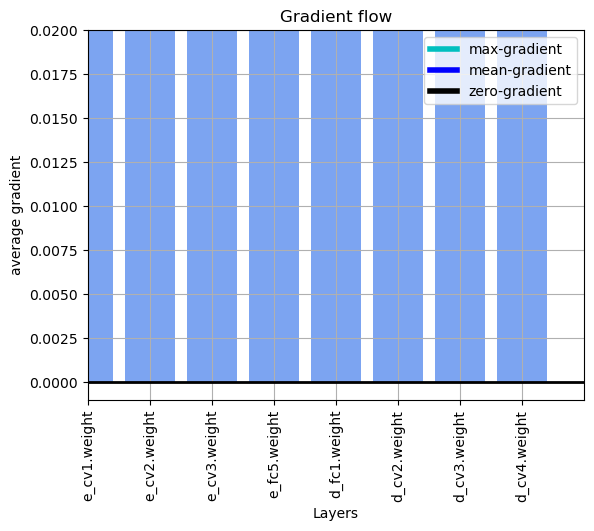

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


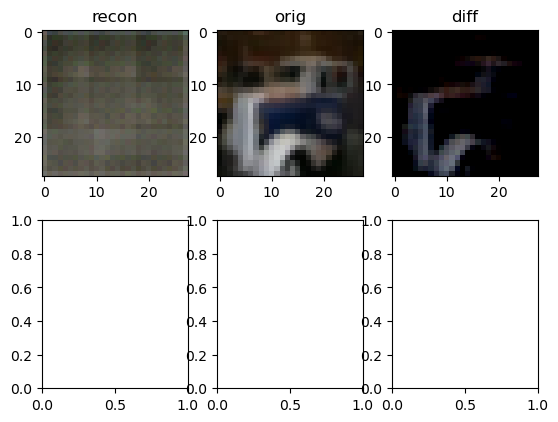

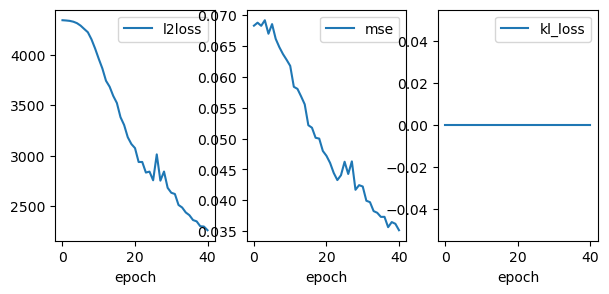

 60% (60 of 100) |#############          | Elapsed Time: 0:00:27 ETA:   0:00:17


 {'epoch': 60, 'train_mse': 0.029851708561182022, 'train_l2_loss': 1919.04833984375, 'train_kl_loss': 0.0}


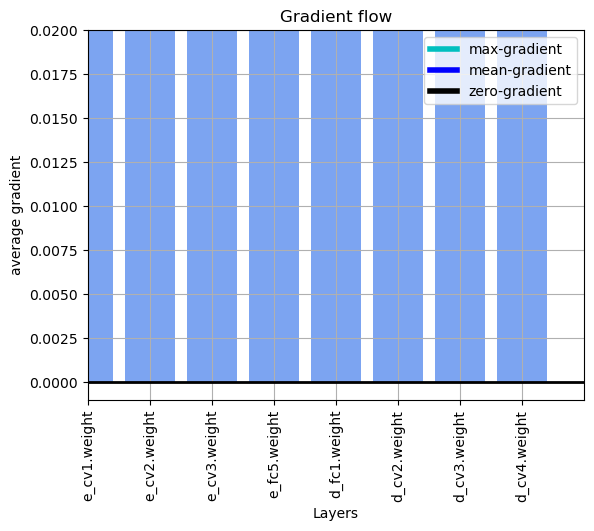

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


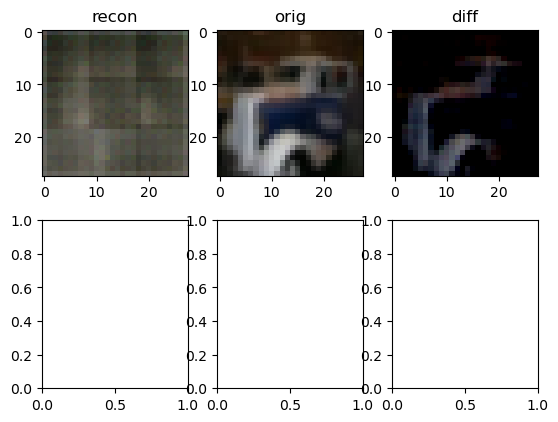

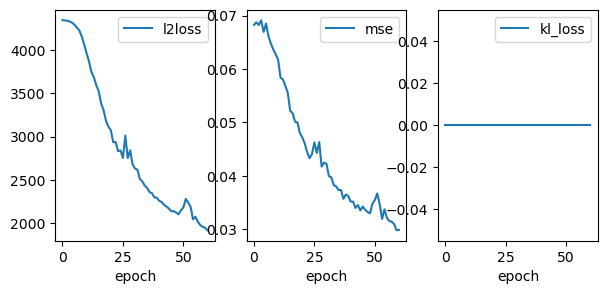

 80% (80 of 100) |##################     | Elapsed Time: 0:00:37 ETA:   0:00:09


 {'epoch': 80, 'train_mse': 0.024895355105400085, 'train_l2_loss': 1583.024658203125, 'train_kl_loss': 0.0}


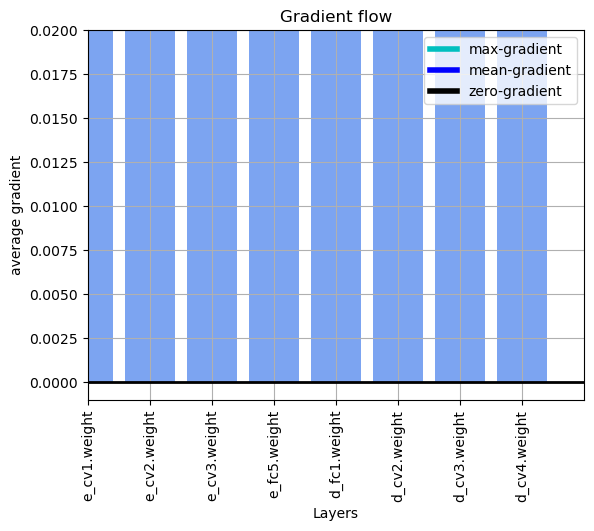

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


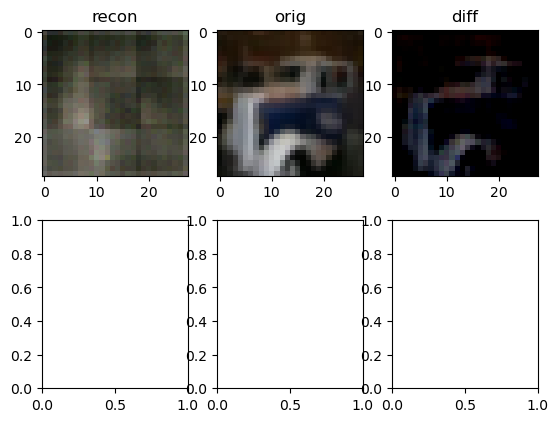

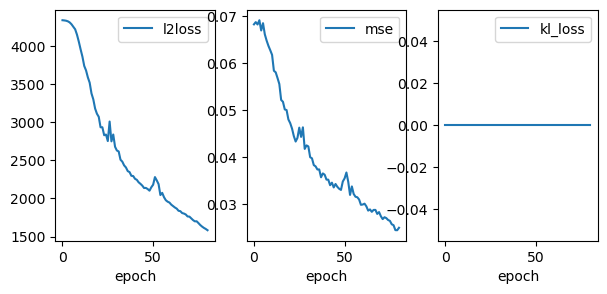

 99% (99 of 100) |###################### | Elapsed Time: 0:00:46 ETA:   0:00:00


 {'epoch': 99, 'train_mse': 0.021789293736219406, 'train_l2_loss': 1392.5684814453125, 'train_kl_loss': 0.0}


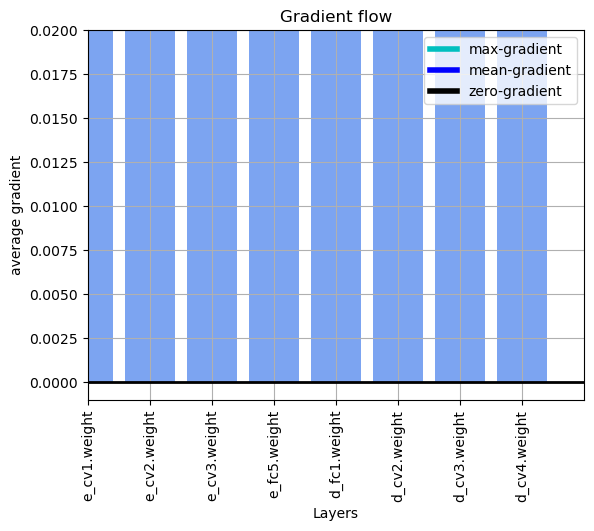

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


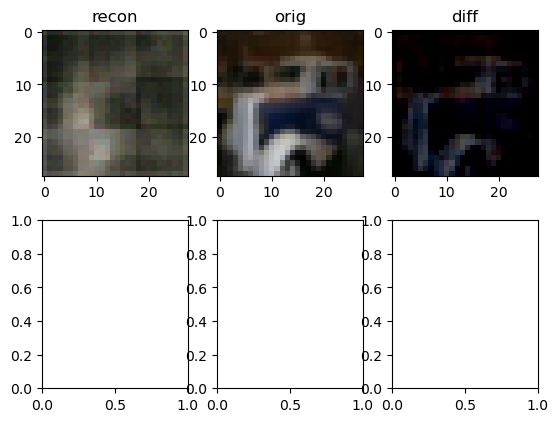

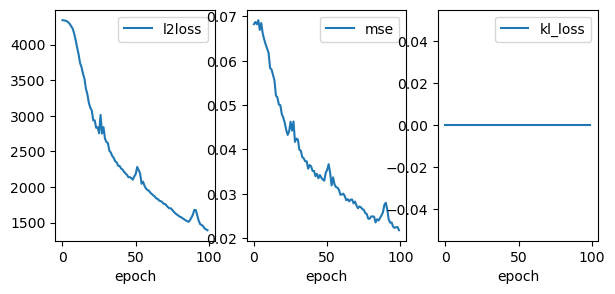

100% (100 of 100) |######################| Elapsed Time: 0:00:47 Time:  0:00:47


In [9]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, vis_frequency=20)

## Variational Autoencoder (CNN)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06787832826375961, 'train_l2_loss': 4342.44140625, 'train_kl_loss': 437.5016174316406}


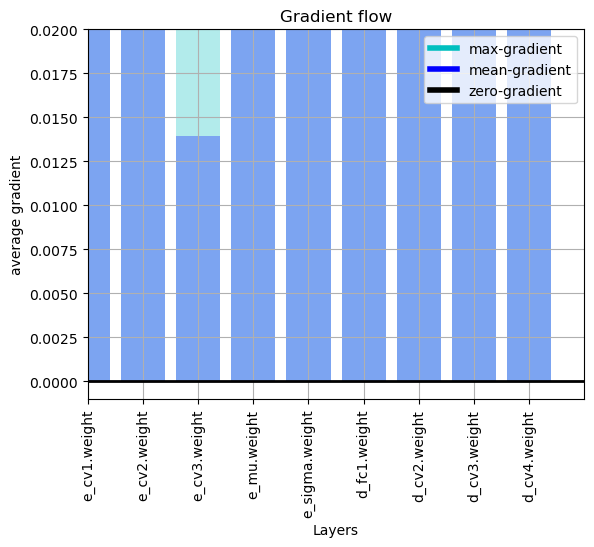

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


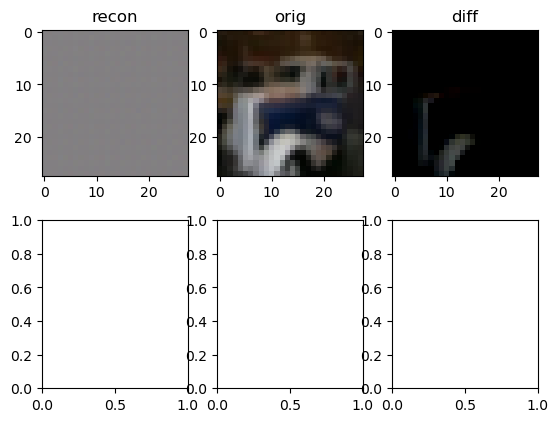

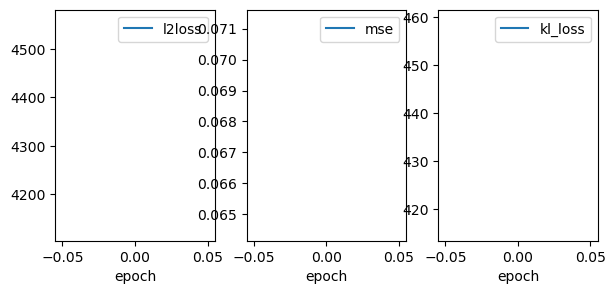

 20% (20 of 100) |####                   | Elapsed Time: 0:00:09 ETA:   0:00:37


 {'epoch': 20, 'train_mse': 0.060976892709732056, 'train_l2_loss': 3962.742431640625, 'train_kl_loss': 552.0189819335938}


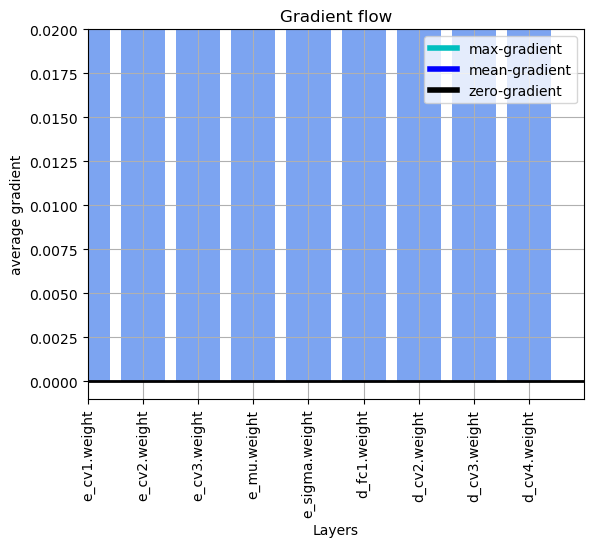

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


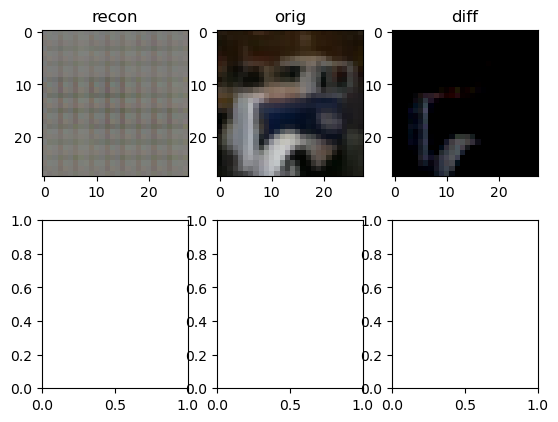

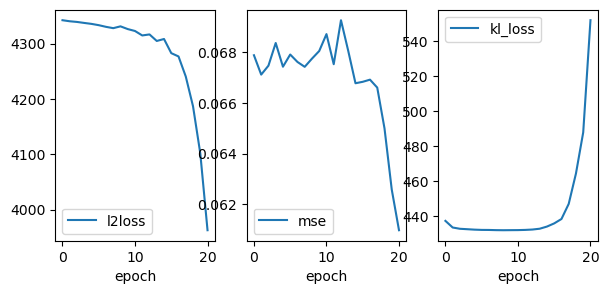

 40% (40 of 100) |#########              | Elapsed Time: 0:00:20 ETA:   0:00:27


 {'epoch': 40, 'train_mse': 0.042371317744255066, 'train_l2_loss': 2774.49560546875, 'train_kl_loss': 737.1744995117188}


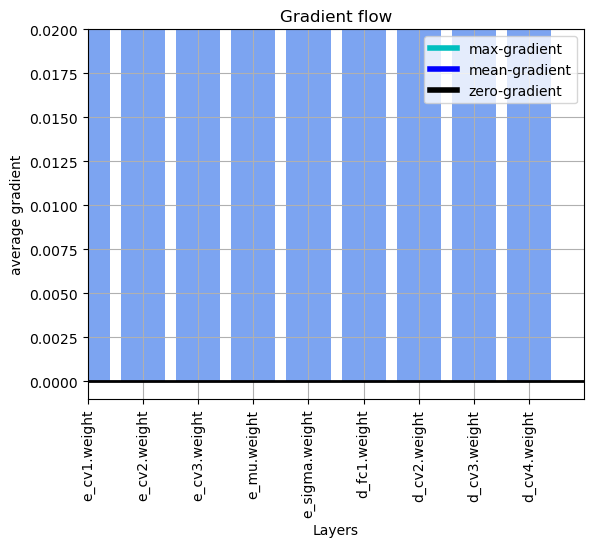

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


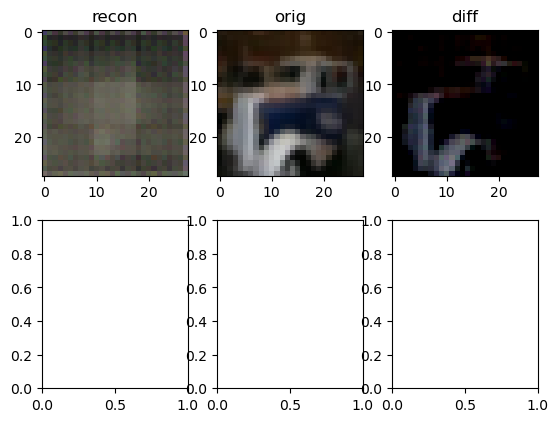

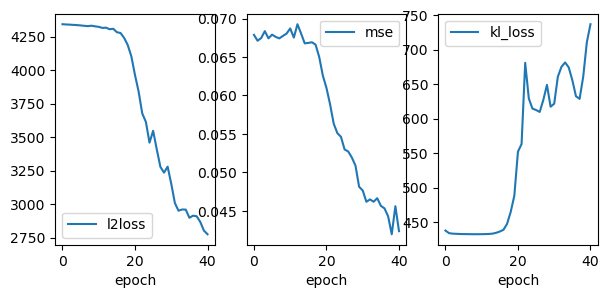

 60% (60 of 100) |#############          | Elapsed Time: 0:00:30 ETA:   0:00:18


 {'epoch': 60, 'train_mse': 0.03882243484258652, 'train_l2_loss': 2495.181884765625, 'train_kl_loss': 727.3369140625}


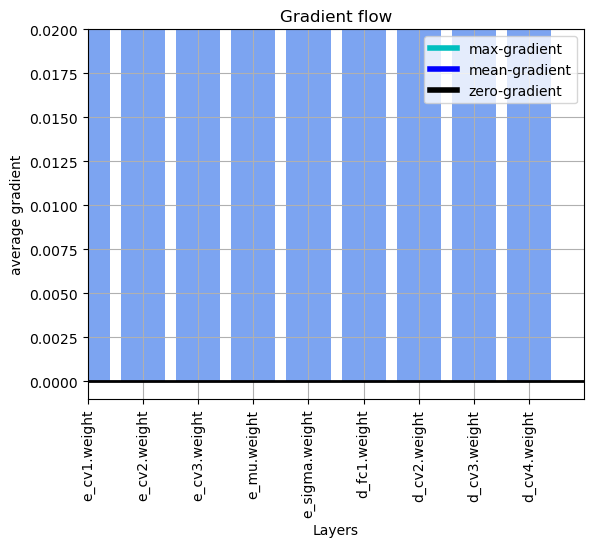

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


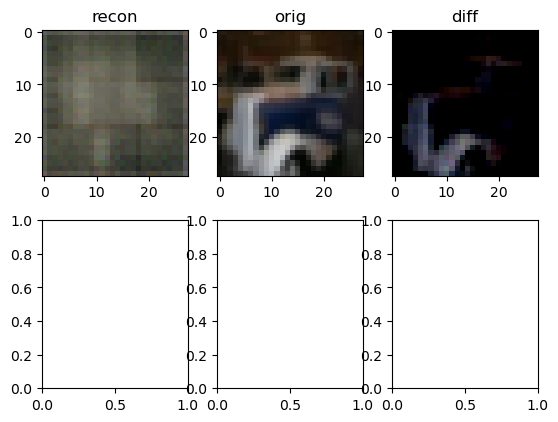

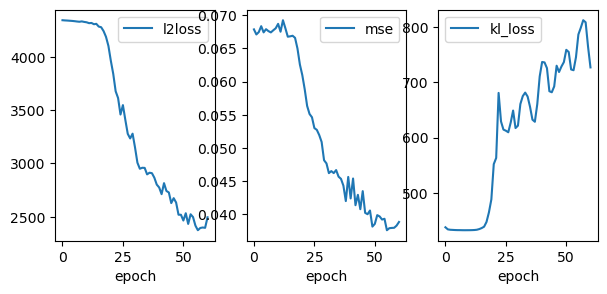

 80% (80 of 100) |##################     | Elapsed Time: 0:00:40 ETA:   0:00:09


 {'epoch': 80, 'train_mse': 0.03612290322780609, 'train_l2_loss': 2206.5712890625, 'train_kl_loss': 762.7716064453125}


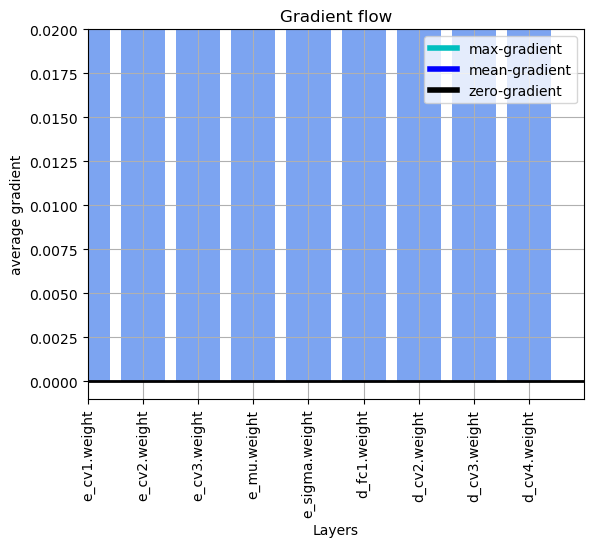

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


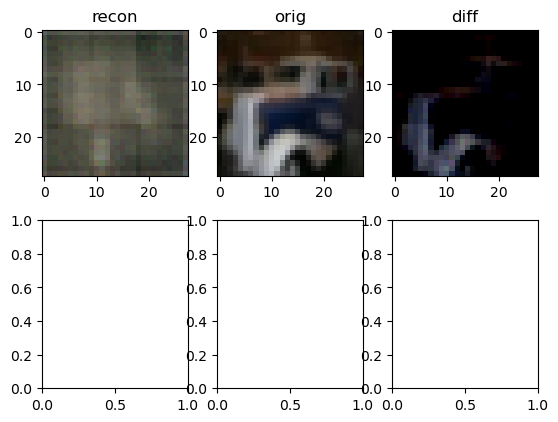

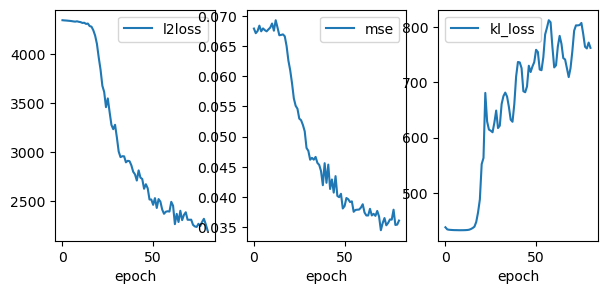

 99% (99 of 100) |###################### | Elapsed Time: 0:00:50 ETA:   0:00:00


 {'epoch': 99, 'train_mse': 0.033875077962875366, 'train_l2_loss': 2120.8076171875, 'train_kl_loss': 799.9752197265625}


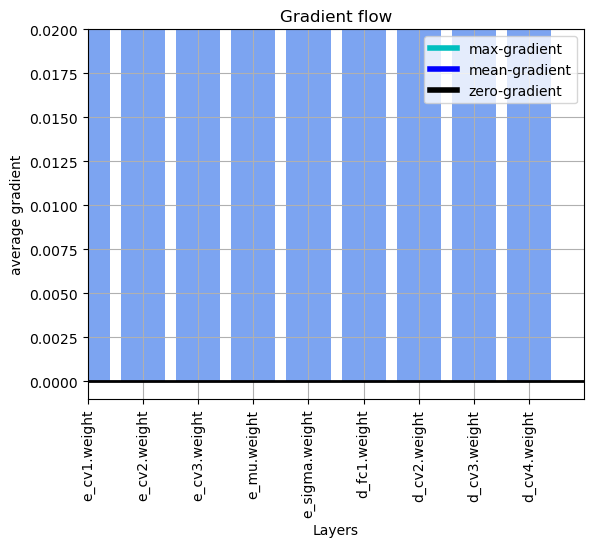

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


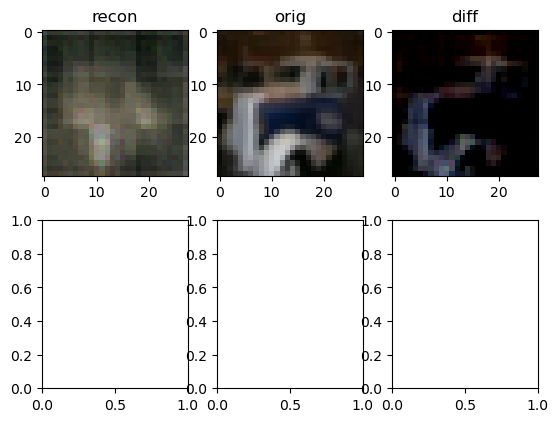

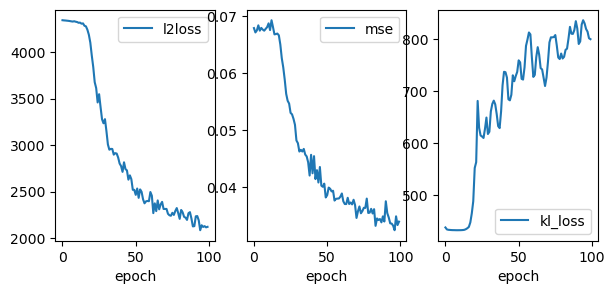

100% (100 of 100) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


In [10]:
model = CVAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, vis_frequency=20)